# Use of [textsplit](https://github.com/chschock/textsplit) repository to segment academic papers

- Uses word2vec
- Adapted from HowTo.iypnb in textsplit repo

### Imports

In [3]:
import os
import word2vec
import pandas as pd
import gensim
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
from textsplit.tools import SimpleSentenceTokenizer
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

Matplotlib is building the font cache; this may take a moment.


### Preprocess Target Text to Segment

In [23]:
import PyPDF2

def add_eof_marker(pdf_file_path):
    """Adds the %%EOF marker at the end of a PDF file if missing."""
    try:
        with open(pdf_file_path, 'rb') as file:
            file.seek(-512, 2)  # Seek to the last 512 bytes
            content = file.read()

            # Check if the %%EOF marker is missing
            if b"%%EOF" not in content:
                print("%%EOF marker is missing. Adding it now.")
                
                # Append the %%EOF marker at the end of the file
                with open(pdf_file_path, 'ab') as append_file:  # Open file in append mode
                    append_file.write(b"\n%%EOF\n")
                print("%%EOF marker added successfully.")
            else:
                print("The PDF already contains a valid %%EOF marker.")
    except Exception as e:
        print(f"Error processing the PDF: {e}")

def pdf_to_txt(pdf_file_path):
    """Converts a PDF file to text."""
    try:
        with open(pdf_file_path, 'rb') as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            text = ""
            
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                page_text = page.extract_text()
                if page_text:
                    text += page_text
                else:
                    print(f"Warning: No text extracted from page {page_num + 1}")

        return text
    except Exception as e:
        print(f"Error while processing the PDF: {e}")
        return ""

In [ ]:
target_pdf_path = "textsplit-paper-ex.ipynb"
add_eof_marker(target_pdf_path)
pdf_to_txt(target_pdf_path)

The PDF already contains a valid %%EOF marker.
Error while repairing the PDF: startxref not found
Error while processing the PDF: startxref not found


''

### Pre-Process Corpus & Word2Vec

- Only need to "train" word vectors on a text corpus once, and keep wrdvecs.bin file around to load into model
  - Can also use pre-trained word2vec, this code re-trains word2vec on custom text corpus

- Text corpus should be txt file
  - best practices: corpus should already betokenized, lower case, UTF-8 encoding, and large

In [ ]:
# corpus_path = "./text8" # corpus downloaded from Matt 
# wrdvec_path = 'wrdvecs.bin'
# # don't need to re-train word vectors if this file exists
# if not os.path.exists(wrdvec_path):
#     %time word2vec.word2vec(corpus_path, wrdvec_path, cbow=1, iter_=5, hs=1, threads=8, sample='1e-5', window=15, size=200, binary=1)

In [ ]:
# Specify the path to the model file (replace with your path)
wrdvecs_path = './data/GoogleNews-vectors-negative300.bin'

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(wrdvecs_path, binary=True)
model.save("google_news_word2vec.model")

wrdvecs = pd.DataFrame(model.vectors, index=model.key_to_index.keys())
del model
# Print the shape of the word vectors DataFrame
print("wrdvecs.shape", wrdvecs.shape)

wrdvecs.shape (3000000, 300)


## Textsplit Algorithm

In [46]:
sentence_tokenizer = SimpleSentenceTokenizer()

segment_len = 10 # segment target length in sentences
path = os.path.basename("just-text-sample.txt")

with open(path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
vecr = CountVectorizer(vocabulary=wrdvecs.index)
sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)

In [47]:
penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

penalty 5.62
65 sentences, 6 segments, avg 10.83 sentences per segment


optimal score 1029.73, greedy score 1029.00
ratio of scores 1.0007


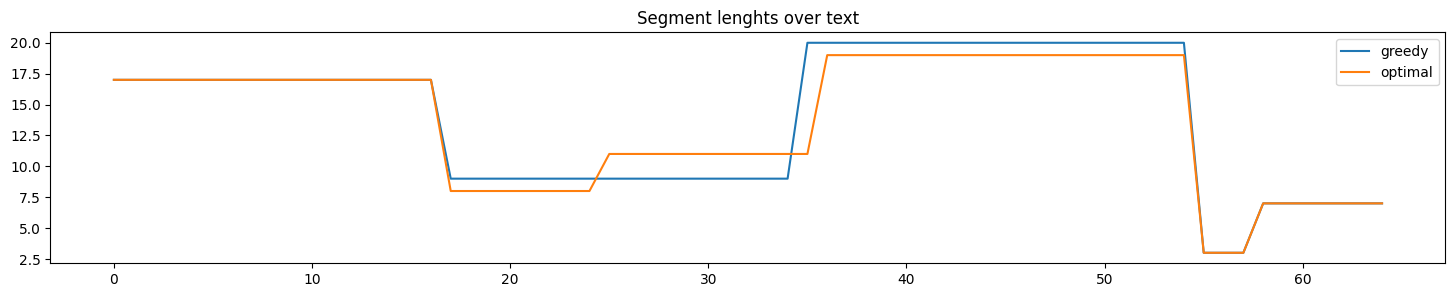

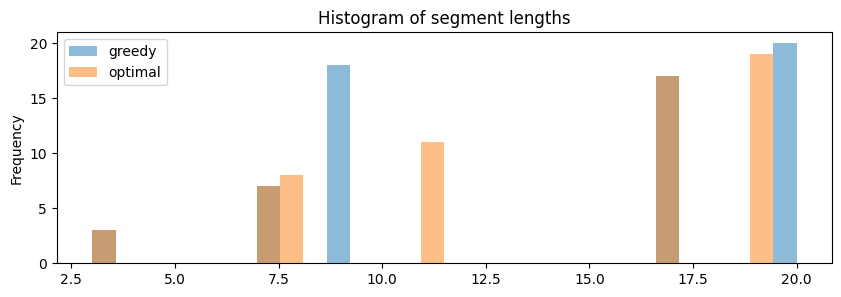

In [ ]:
greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lengths over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))